In [1]:
!pip install shap

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import shap

In [3]:
df = pd.read_csv("stackoverflow_full.csv")

# **Data Cleaning**

## **เช็คค่า Null**

In [4]:
df.isnull().sum()

,0
Unnamed: 0,0
Age,0
Accessibility,0
EdLevel,0
Employment,0
Gender,0
MentalHealth,0
MainBranch,0
YearsCode,0
YearsCodePro,0


## **ลบข้อมูลที่มีค่าเป็น Null ออกทั้งหมด**

In [5]:
df.dropna(inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73399 entries, 0 to 73461
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      73399 non-null  int64  
 1   Age             73399 non-null  object 
 2   Accessibility   73399 non-null  object 
 3   EdLevel         73399 non-null  object 
 4   Employment      73399 non-null  int64  
 5   Gender          73399 non-null  object 
 6   MentalHealth    73399 non-null  object 
 7   MainBranch      73399 non-null  object 
 8   YearsCode       73399 non-null  int64  
 9   YearsCodePro    73399 non-null  int64  
 10  Country         73399 non-null  object 
 11  PreviousSalary  73399 non-null  float64
 12  HaveWorkedWith  73399 non-null  object 
 13  ComputerSkills  73399 non-null  int64  
 14  Employed        73399 non-null  int64  
dtypes: float64(1), int64(6), object(8)
memory usage: 9.0+ MB


## **Drop Column Unname ทิ้ง**

In [6]:
df.drop(["Unnamed: 0"], axis = 1, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73399 entries, 0 to 73461
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             73399 non-null  object 
 1   Accessibility   73399 non-null  object 
 2   EdLevel         73399 non-null  object 
 3   Employment      73399 non-null  int64  
 4   Gender          73399 non-null  object 
 5   MentalHealth    73399 non-null  object 
 6   MainBranch      73399 non-null  object 
 7   YearsCode       73399 non-null  int64  
 8   YearsCodePro    73399 non-null  int64  
 9   Country         73399 non-null  object 
 10  PreviousSalary  73399 non-null  float64
 11  HaveWorkedWith  73399 non-null  object 
 12  ComputerSkills  73399 non-null  int64  
 13  Employed        73399 non-null  int64  
dtypes: float64(1), int64(5), object(8)
memory usage: 8.4+ MB


# **Exploratory Data Analysis (EDA)**

## **Plot Categorical Column โดยดูจำนวนในแต่ละประเภท และความน่าจะเป็นที่จะถูกรับเข้าทำงาน**

In [7]:
def plot_categorical_column(df, col):
    # Countplot
    plt.figure(figsize=(10,4))
    sns.countplot(data=df, x=col)
    plt.title(f"Countplot of {col}")
    plt.xticks(rotation=45)
    plt.show()

    # Target percentage per category
    plt.figure(figsize=(10,4))
    target_rate = df.groupby(col)['Employed'].mean().sort_values(ascending=False)
    sns.barplot(x=target_rate.index, y=target_rate.values)
    plt.xticks(rotation=45)
    plt.ylabel("P(Employed=1)")
    plt.title(f"Employment Rate by {col}")
    plt.show()

### **Age**

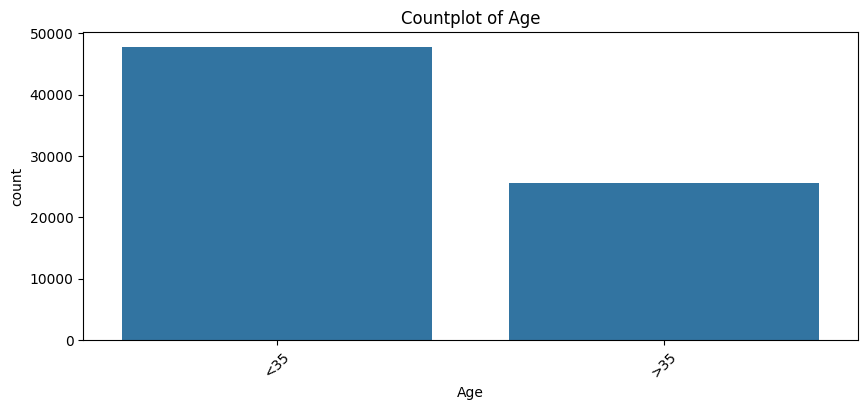

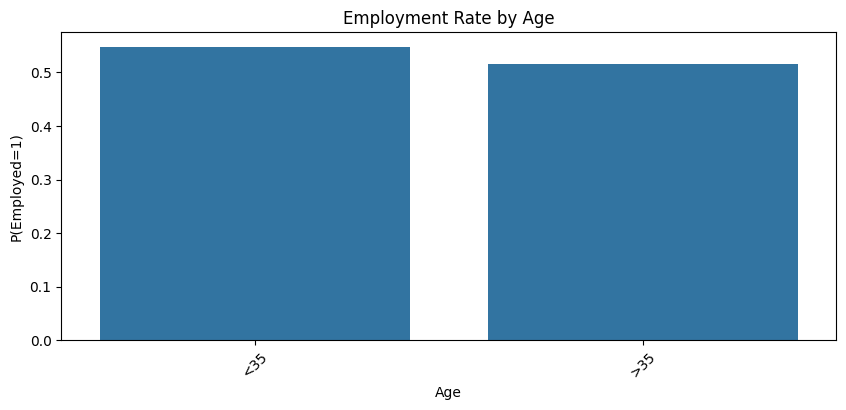

In [8]:
plot_categorical_column(df, "Age")

**Age ทั้ง 2 ประเภทมีความน่าจะเป็นที่จะถูกรับเข้าทำงานใกล้กันมาก ดังนั้น Feature นี้แทบไม่ส่งผลต่อการถูกรับเข้าทำงาน**

### **Accessibility**

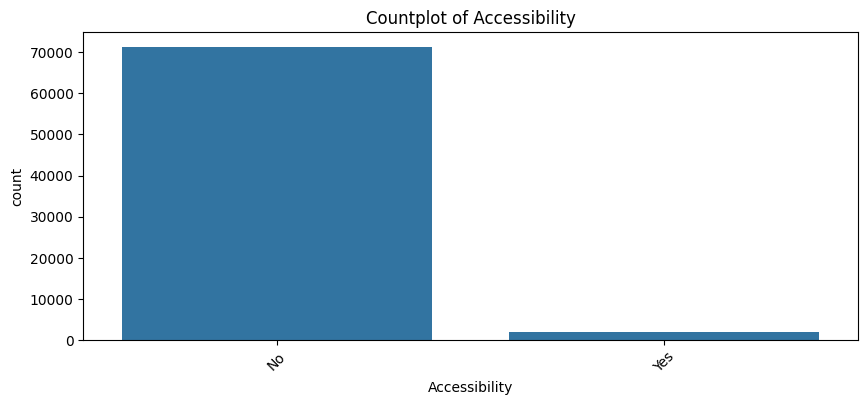

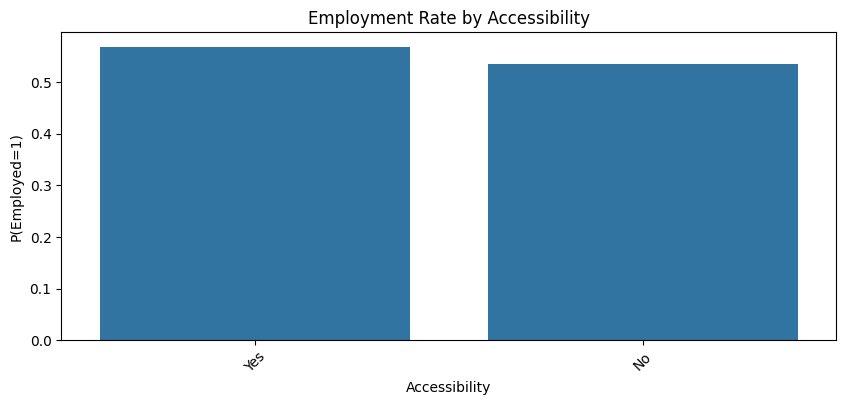

In [9]:
plot_categorical_column(df, "Accessibility")

**Accessibility ทั้ง 2 ประเภทมีความน่าจะเป็นที่จะถูกรับเข้าทำงานใกล้กันมาก ดังนั้น Feature นี้แทบไม่ส่งผลต่อการถูกรับเข้าทำงาน**

### **Gender**

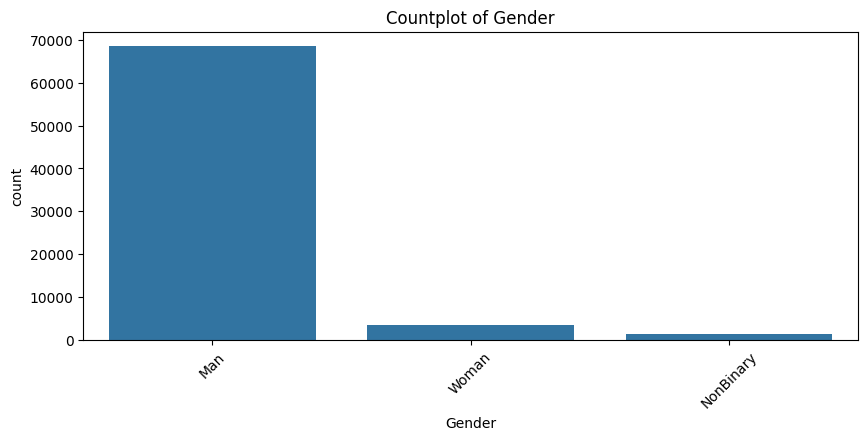

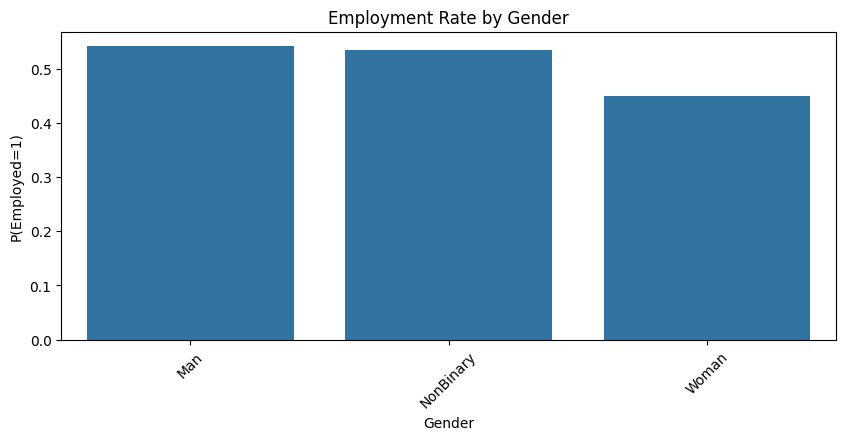

In [10]:
plot_categorical_column(df, "Gender")

**เพศ ทั้ง 3 ประเภทมีความน่าจะเป็นที่จะถูกรับเข้าทำงานใกล้กันมาก ดังนั้น Feature นี้แทบไม่ส่งผลต่อการถูกรับเข้าทำงาน**

### **Mental Health**

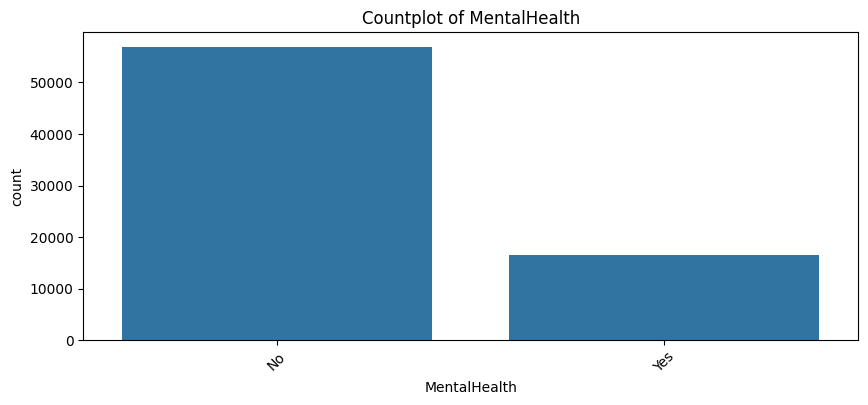

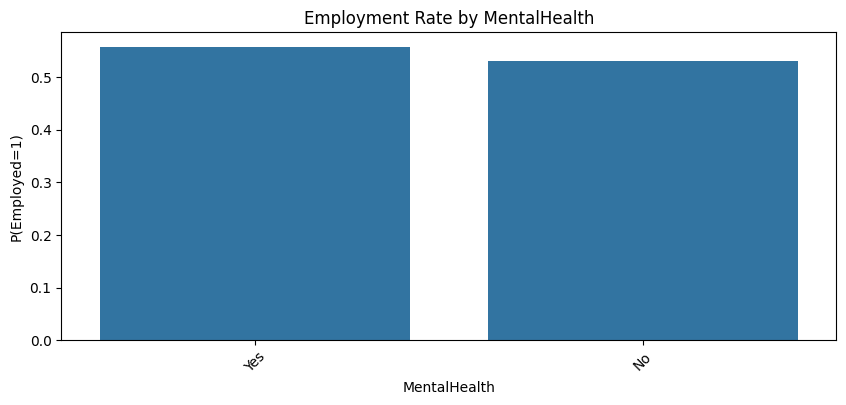

In [11]:
plot_categorical_column(df, "MentalHealth")

**Mental Health ทั้ง 2 ประเภทมีความน่าจะเป็นที่จะถูกรับเข้าทำงานใกล้กันมาก ดังนั้น Feature นี้แทบไม่ส่งผลต่อการถูกรับเข้าทำงาน**

### **Education Level**

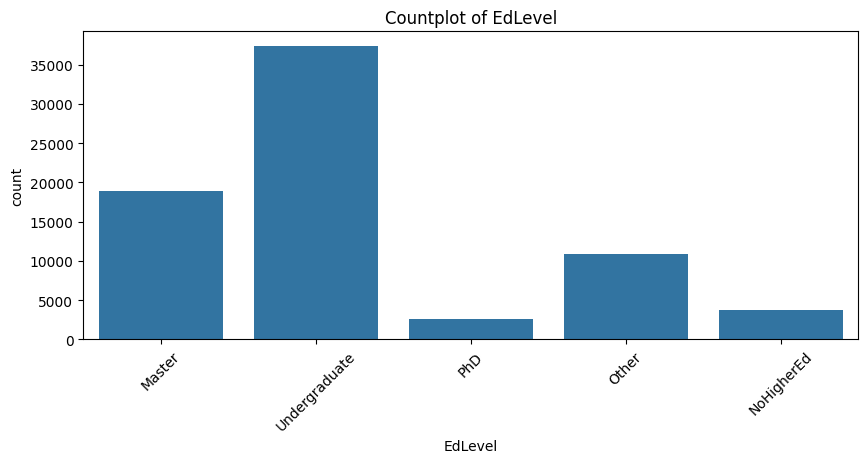

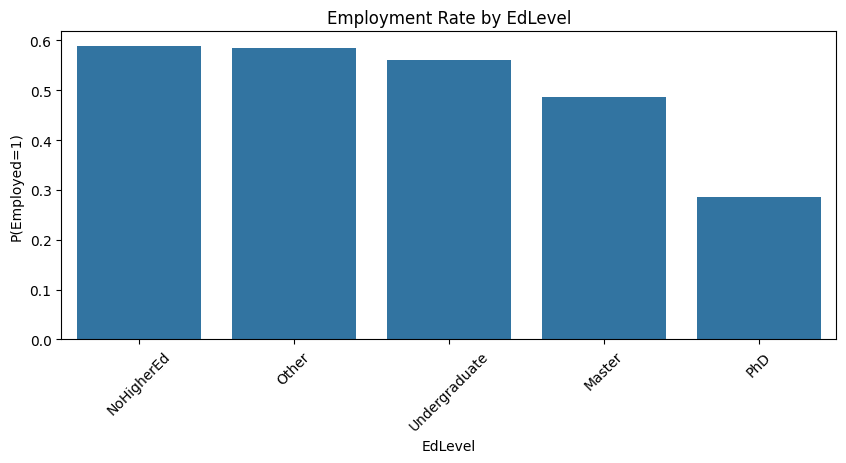

In [12]:
plot_categorical_column(df, "EdLevel")

#### **ทดสอบว่าการศึกษามีผลต่อการถูกรับเข้าทำงานหรือไม่**

In [13]:
from scipy.stats import chi2_contingency
contingency_table = pd.crosstab(df["EdLevel"], df["Employed"])
contingency_table

chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)

print(f"Chi-square Test: {chi2_stat:.4f}")
print(f"P-value: {p_value:.4e}")

alpha = 0.01
if p_value < alpha:
    print("ผลลัพธ์: มีนัยสำคัญทางสถิติ (ปฏิเสธ H0) ดังนั้นการศึกษามีผลต่อการถูกรับเข้าทำงาน")
else:
    print("ผลลัพธ์: ไม่มีนัยสำคัญทางสถิติ (ยอมรับ H0) ดังนั้นการศึกษาไม่มีผลต่อการถูกรับเข้าทำงาน")

Chi-square Test: 1076.4594
P-value: 9.5846e-232
ผลลัพธ์: มีนัยสำคัญทางสถิติ (ปฏิเสธ H0) ดังนั้นการศึกษามีผลต่อการถูกรับเข้าทำงาน


### **Main Branch**

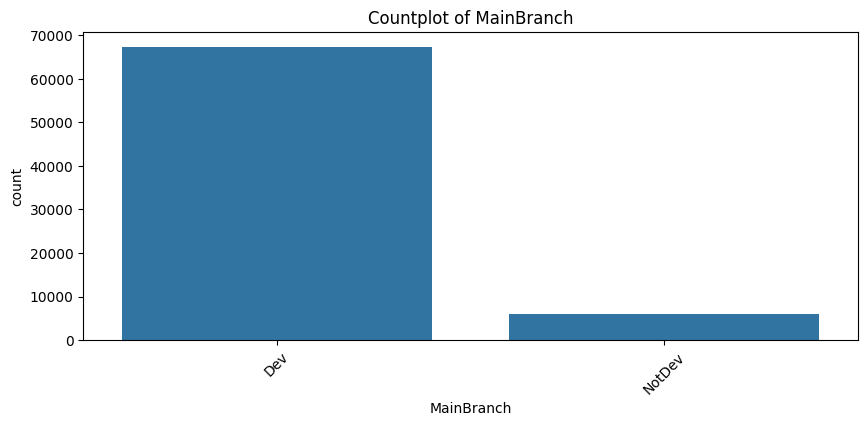

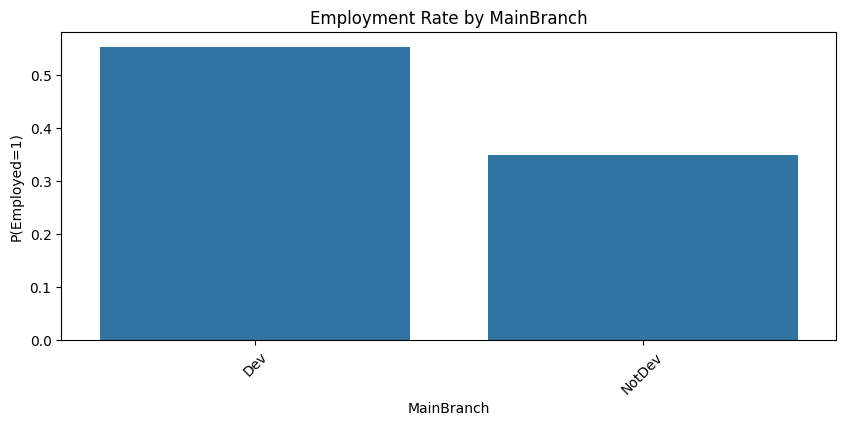

In [14]:
plot_categorical_column(df, "MainBranch")

#### **ทดสอบว่า Main Branch มีผลต่อการถูกรับเข้าทำงานหรือไม่**

In [15]:
contingency_table = pd.crosstab(df["MainBranch"], df["Employed"])
contingency_table

chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)

print(f"Chi-square Test: {chi2_stat:.4f}")
print(f"P-value: {p_value:.4e}")

alpha = 0.05
if p_value < alpha:
    print("ผลลัพธ์: มีนัยสำคัญทางสถิติ (ปฏิเสธ H0) ดังนั้น Main Branch มีผลต่อการถูกรับเข้าทำงาน")
else:
    print("ผลลัพธ์: ไม่มีนัยสำคัญทางสถิติ (ยอมรับ H0) ดังนั้น Main Branch ไม่มีผลต่อการถูกรับเข้าทำงาน")

Chi-square Test: 922.0604
P-value: 1.5712e-202
ผลลัพธ์: มีนัยสำคัญทางสถิติ (ปฏิเสธ H0) ดังนั้น Main Branch มีผลต่อการถูกรับเข้าทำงาน


### **Drop Column ที่แทบไม่ส่งผลต่อการถูกรับเข้าทำงาน จากการสังเกตกราฟด้านบน**

In [16]:
df.drop(columns = ['Age','Accessibility','Gender', 'MentalHealth'], inplace = True)

### **Country**

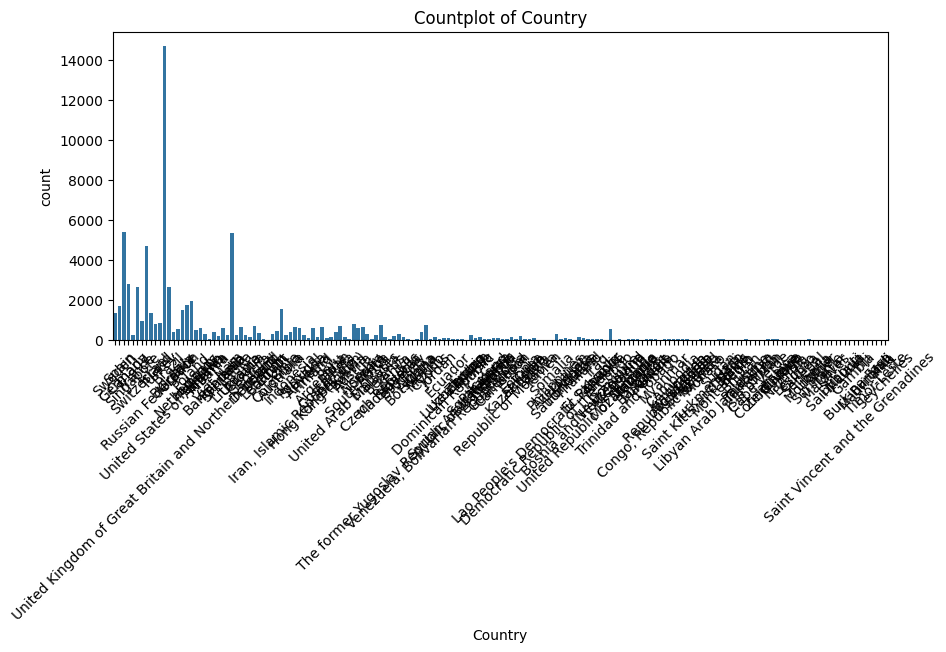

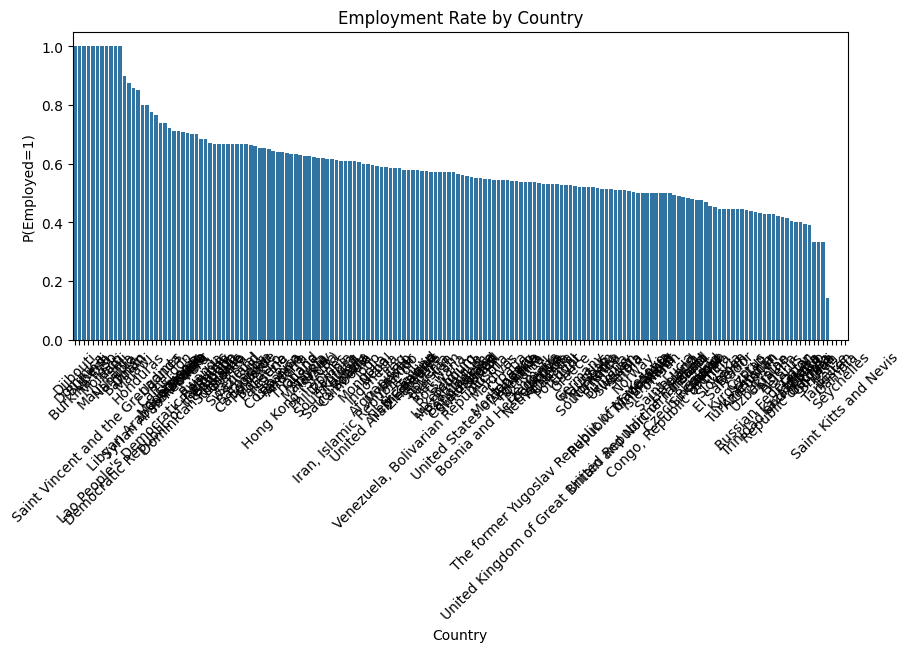

In [17]:
plot_categorical_column(df, "Country")

## **Plot Numerical Column เพื่อดู Distrubution**

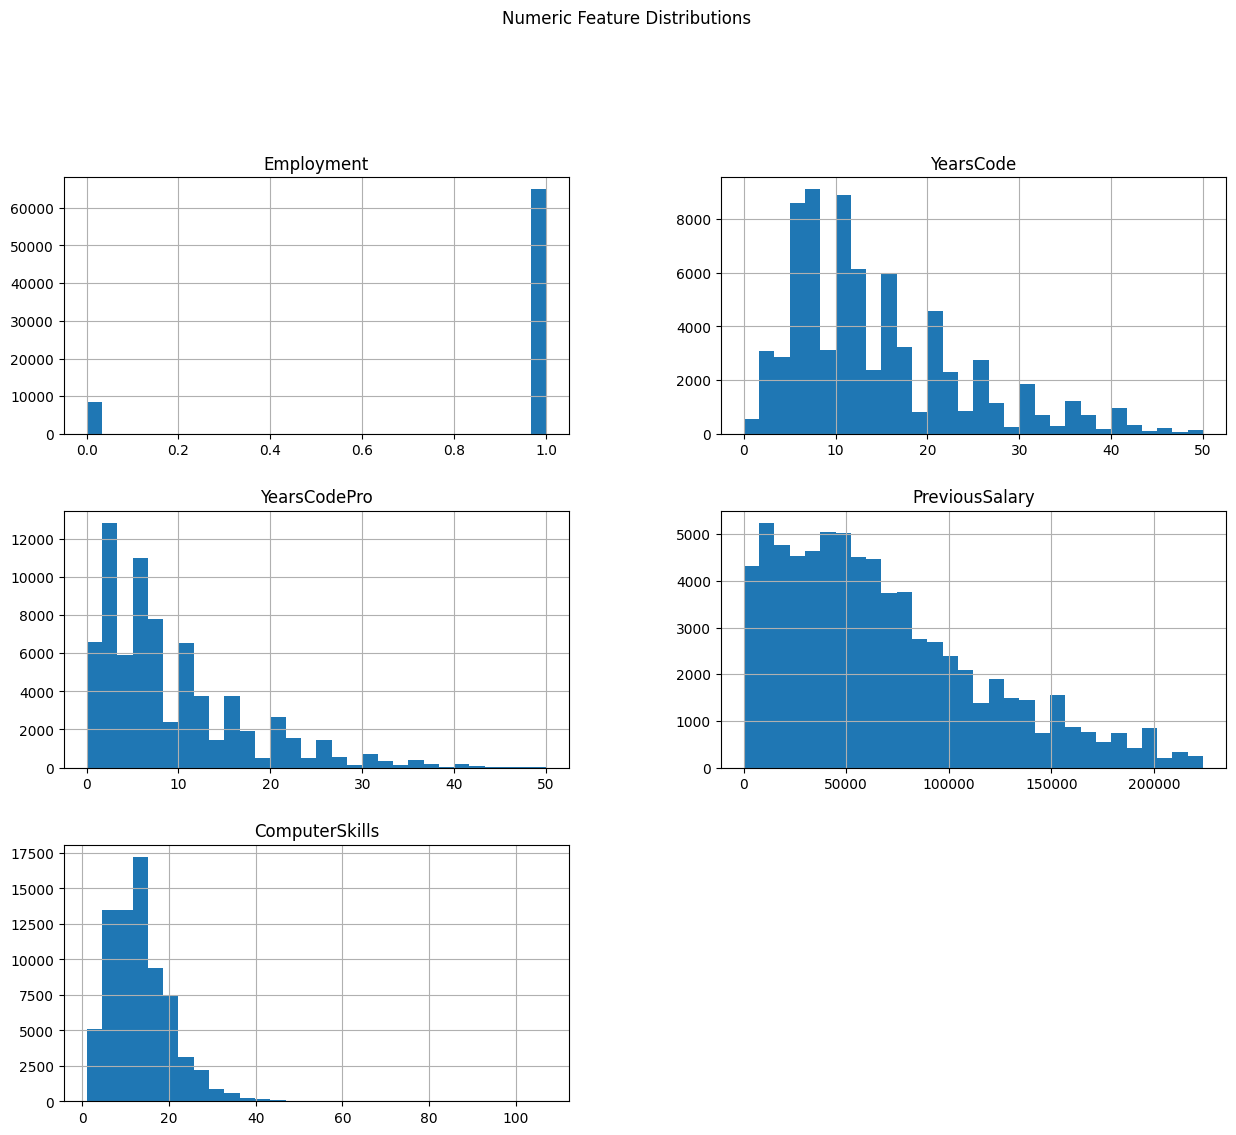

In [18]:
numeric_cols = df.select_dtypes(include=['int64','float64']).columns.drop('Employed')

df[numeric_cols].hist(figsize=(15,12), bins=30)
plt.suptitle("Numeric Feature Distributions", y=1.02)
plt.show()

**Employment เป็น Categorical Feature เพราะมีแค่ 2 ประเภทคือ Yes/No**

### **ตรวจสอบ Outlier**

In [19]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop(['Employed','Employment'])
iqr_summary = []

for col in numeric_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    n_outliers = ((df[col] < lower) | (df[col] > upper)).sum()
    pct_outliers = n_outliers / len(df) * 100

    iqr_summary.append({
        "feature": col,
        "Q1": q1,
        "Q3": q3,
        "IQR": iqr,
        "lower_fence": lower,
        "upper_fence": upper,
        "#outliers": n_outliers,
        "%outliers": pct_outliers
    })

iqr_df = pd.DataFrame(iqr_summary).sort_values("%outliers", ascending=False)
display(iqr_df)

,feature,Q1,Q3,IQR,lower_fence,upper_fence,#outliers,%outliers
1,YearsCodePro,3.0,12.0,9.0,-10.5,25.5,3349,4.562732
0,YearsCode,7.0,20.0,13.0,-12.5,39.5,1809,2.464611
3,ComputerSkills,8.0,17.0,9.0,-5.5,30.5,1633,2.224826
2,PreviousSalary,28860.0,95979.0,67119.0,-71818.5,196657.5,1479,2.015014


**Outlier ในข้อมูลมีน้อยมาก**

### **ดู Coleration ระหว่าง Feature ที่เป็นตัวเลข**

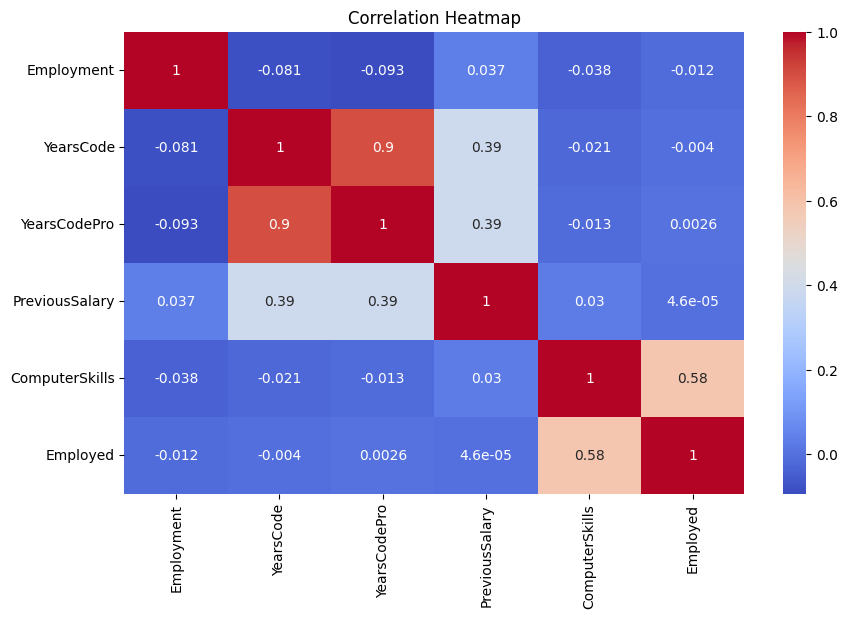

In [20]:
numerical_cols = df.select_dtypes(include=['number']).columns
plt.figure(figsize=(10,6))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

**จะเห็นว่า Computer Skills ส่งผลต่อการถูกรับเข้าทำงานมาก โดยยิ่งมี Skill มาก จะยิ่งส่งผลต่อการถูกรับเข้าทำงานมากขึ้น
และเงินเดือนล่าสุด แทบจะไม่ส่งผลกับการถูกรับเข้าทำงานเลย**

## **ตรวจสอบ Feature HaveWorkedWith**

In [21]:
df['HaveWorkedWith'].head()

,HaveWorkedWith
0,C++;Python;Git;PostgreSQL
1,Bash/Shell;HTML/CSS;JavaScript;Node.js;SQL;Typ...
2,C;C++;Java;Perl;Ruby;Git;Ruby on Rails
3,Bash/Shell;HTML/CSS;JavaScript;PHP;Ruby;SQL;Gi...
4,C++;Python


In [22]:
from sklearn.feature_extraction.text import CountVectorizer

text_col = "HaveWorkedWith"

vectorizer = CountVectorizer(stop_words="english")
word_matrix = vectorizer.fit_transform(df[text_col].astype(str))
word_counts = np.asarray(word_matrix.sum(axis=0)).ravel()
vocab = np.array(vectorizer.get_feature_names_out())

freq_df = pd.DataFrame({"word": vocab, "count": word_counts})
freq_df = freq_df.sort_values("count", ascending=False)

print("Top 20 most common tools/skills:")
display(freq_df.head(20))

Top 20 most common tools/skills:


,word,count
58,js,73460
104,sql,58466
56,javascript,49347
28,docker,40224
52,html,40207
20,css,40207
69,microsoft,38068
45,git,35911
6,aws,31590
91,python,31159


In [23]:
print(freq_df.shape[0])

119


**จะเห็นว่า JavaScript (JS), SQL, Docker, HTML และ CSS  เป็น Skill ที่มีคนที่เคยทำงานผ่านมาแล้วเยอะที่สุด แสดงว่าคนส่วนใหญ่เคยทำงานเกี่ยวกับการเขียน Web Application เยอะ**

### **ทำ One Hot Encoding สำหรับ Feature HaveWorkedWith และ Country**

In [24]:
skills_dummies = df['HaveWorkedWith'].str.get_dummies(sep=';')
country_dummies = df['Country'].str.get_dummies()
df = pd.concat([df, skills_dummies, country_dummies], axis=1)

df.drop('HaveWorkedWith', axis=1, inplace=True)

df.head()

,EdLevel,Employment,MainBranch,YearsCode,YearsCodePro,Country,PreviousSalary,ComputerSkills,Employed,APL,...,United Kingdom of Great Britain and Northern Ireland,United Republic of Tanzania,United States of America,Uruguay,Uzbekistan,"Venezuela, Bolivarian Republic of...",Viet Nam,Yemen,Zambia,Zimbabwe
0,Master,1,Dev,7,4,Sweden,51552.0,4,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Undergraduate,1,Dev,12,5,Spain,46482.0,12,1,0,...,0,0,0,0,0,0,0,0,0,0
2,Master,1,Dev,15,6,Germany,77290.0,7,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Undergraduate,1,Dev,9,6,Canada,46135.0,13,0,0,...,0,0,0,0,0,0,0,0,0,0
4,PhD,0,NotDev,40,30,Singapore,160932.0,2,0,0,...,0,0,0,0,0,0,0,0,0,0


## **ทำ Label Encoder สำหรับ Feature ที่เหลือที่ยังมี Type เป็น  Object ทั้งหมด**

In [25]:
le = LabelEncoder()
for col in df.columns:
  if df[col].dtype == "object":
    df[col] = le.fit_transform(df[col])

df.head()

,EdLevel,Employment,MainBranch,YearsCode,YearsCodePro,Country,PreviousSalary,ComputerSkills,Employed,APL,...,United Kingdom of Great Britain and Northern Ireland,United Republic of Tanzania,United States of America,Uruguay,Uzbekistan,"Venezuela, Bolivarian Republic of...",Viet Nam,Yemen,Zambia,Zimbabwe
0,0,1,0,7,4,146,51552.0,4,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,1,0,12,5,141,46482.0,12,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,15,6,54,77290.0,7,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,0,9,6,27,46135.0,13,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3,0,1,40,30,135,160932.0,2,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
df.describe()

,EdLevel,Employment,MainBranch,YearsCode,YearsCodePro,Country,PreviousSalary,ComputerSkills,Employed,APL,...,United Kingdom of Great Britain and Northern Ireland,United Republic of Tanzania,United States of America,Uruguay,Uzbekistan,"Venezuela, Bolivarian Republic of...",Viet Nam,Yemen,Zambia,Zimbabwe
count,73399.000000,73399.000000,73399.000000,73399.000000,73399.000000,73399.000000,73399.000000,73399.000000,73399.000000,73399.000000,...,73399.000000,73399.000000,73399.000000,73399.000000,73399.000000,73399.000000,73399.000000,73399.000000,73399.000000,73399.000000
mean,2.488835,0.883132,0.082358,14.221079,9.100451,98.650159,67765.625118,13.439747,0.536683,0.003025,...,0.063816,0.000436,0.200125,0.002207,0.000599,0.001608,0.002861,0.000123,0.000177,0.000259
std,1.706816,0.321265,0.274911,9.404350,7.960085,54.977537,49492.292504,7.049885,0.498656,0.054913,...,0.244426,0.020876,0.400097,0.046928,0.024477,0.040064,0.053413,0.011073,0.013307,0.016087
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,7.000000,3.000000,54.000000,28860.000000,8.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,1.000000,0.000000,12.000000,7.000000,106.000000,57588.000000,13.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,1.000000,0.000000,20.000000,12.000000,162.000000,95979.000000,17.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4.000000,1.000000,1.000000,50.000000,50.000000,171.000000,224000.000000,107.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# **Preprocssing Data and train Model**

## **จำนวนข้อมูลทั้งหมด ในคลาสแต่ละคลาส**

In [27]:
employedRatio = round(df.Employed .sum() / df.shape[0],2)
unEmployedRatio = round((df.shape[0] - df.Employed.sum()) / df.shape[0],2)
print("Class Distriubtion: \tClass Employed =",employedRatio,"(", int(employedRatio * df.shape[0])
      ,")\n\t\t\tClass UnEmployed =", unEmployedRatio ,"(", int(unEmployedRatio * df.shape[0]), ")" )

Class Distriubtion: 	Class Employed = 0.54 ( 39635 )
			Class UnEmployed = 0.46 ( 33763 )


**จะเห็นว่าไม่เกิดปัญหา Unbalance Class**

## **ดูความสำคัญของ Feature และลบ Feature ที่มีความสำคัญน้อยออกก่อนนำไปฝึกฝนโมเดล**

In [28]:
corr = df.corr()["Employed"].sort_values(ascending=False)
corr.drop("Employed", inplace = True)

In [29]:
for row in corr.index:
  if ( corr[row] < 0.05 and corr[row] > -0.05) :
    corr.drop(row, inplace= True)
    df.drop(row, axis = 1, inplace = True)
corr

,Employed
ComputerSkills,0.584988
Node.js,0.492762
TypeScript,0.468588
JavaScript,0.421224
MongoDB,0.352915
...,...
Symfony,0.057785
Go,0.056897
Terraform,0.052006
OVH,0.050014


<Axes: >

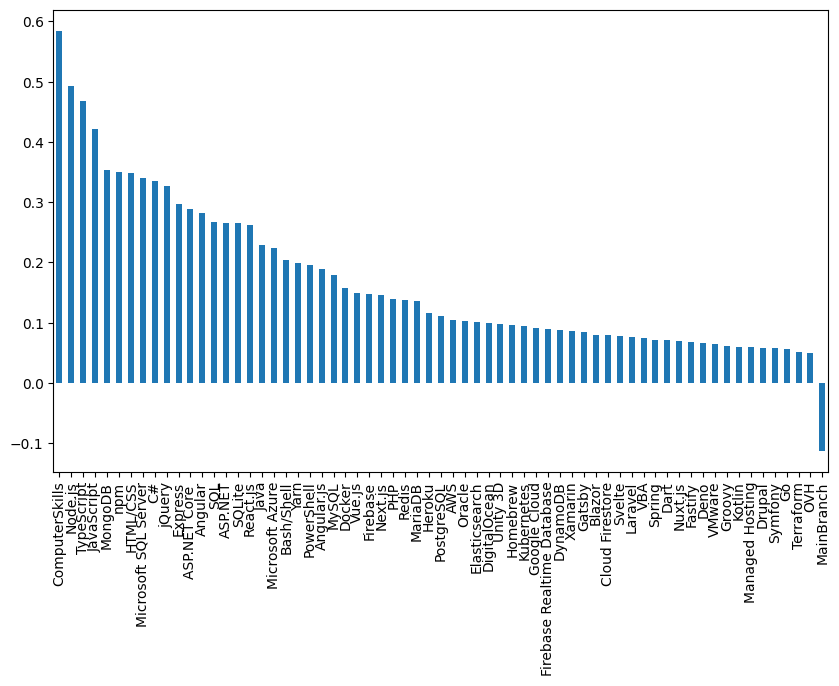

In [30]:
plt.figure(figsize=(10,6))
corr.plot(kind="bar")

**จะเห็นว่า Feature เดิมที่เหลืออยู่ใน Dataset เดิมเหลือแค่ ComputerSkills และ Main Branch ส่วน Feature อื่นเป็น Feature จากการทำ One-hot Encoding จาก Feature HaveWorkedWith เช่น Node.js เป็นต้น**

In [31]:
x = df.drop(["Employed"], axis=1)
y = df["Employed"]

## **Train Test Split**

In [32]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 17)

## **ใช้ Standard Scaler ในการ Normalize ข้อมูล**

In [33]:
scaler = StandardScaler()
scaler.fit(x_train)

StandardScaler()

In [34]:
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [35]:
employedRatio = round(y_train.sum() / y_train.shape[0],2)
unEmployedRatio = round((y_train.shape[0] - y_train.sum()) / y_train.shape[0],2)
print("Training Data: Class Employed =",employedRatio,"(", int(employedRatio * y_train.shape[0])
      ,")\n\t\tClass UnEmployed =", unEmployedRatio ,"(", int(unEmployedRatio * y_train.shape[0]), ")" )

Training Data: Class Employed = 0.53 ( 27230 )
		Class UnEmployed = 0.47 ( 24148 )


# **สร้าง RandomForest และทดสอบกับ Test Set**

In [36]:
randomForest = RandomForestClassifier(oob_score=True
                                      , n_estimators = 550, max_features = 30
                                      ,max_depth = 50, criterion = "entropy")
y_pred = randomForest.fit(x_train, y_train).predict(x_test)
print( "Accuracy Score =", round(accuracy_score(y_pred , y_test),4))
print( "F1 Score =", round( f1_score(y_pred , y_test),4))
print( "Precision Score =", round(precision_score(y_pred , y_test),4))
print( "Recall Score =", round(recall_score(y_pred , y_test),4))
print( "AOC Score = ", round(roc_auc_score(y_test, y_pred),4))
print(f'OOB error: {1 - randomForest.oob_score_:.4f}')

Accuracy Score = 0.9993
F1 Score = 0.9994
Precision Score = 0.9988
Recall Score = 0.9999
AOC Score =  0.9994
OOB error: 0.0010


## **Confusion Matrix**

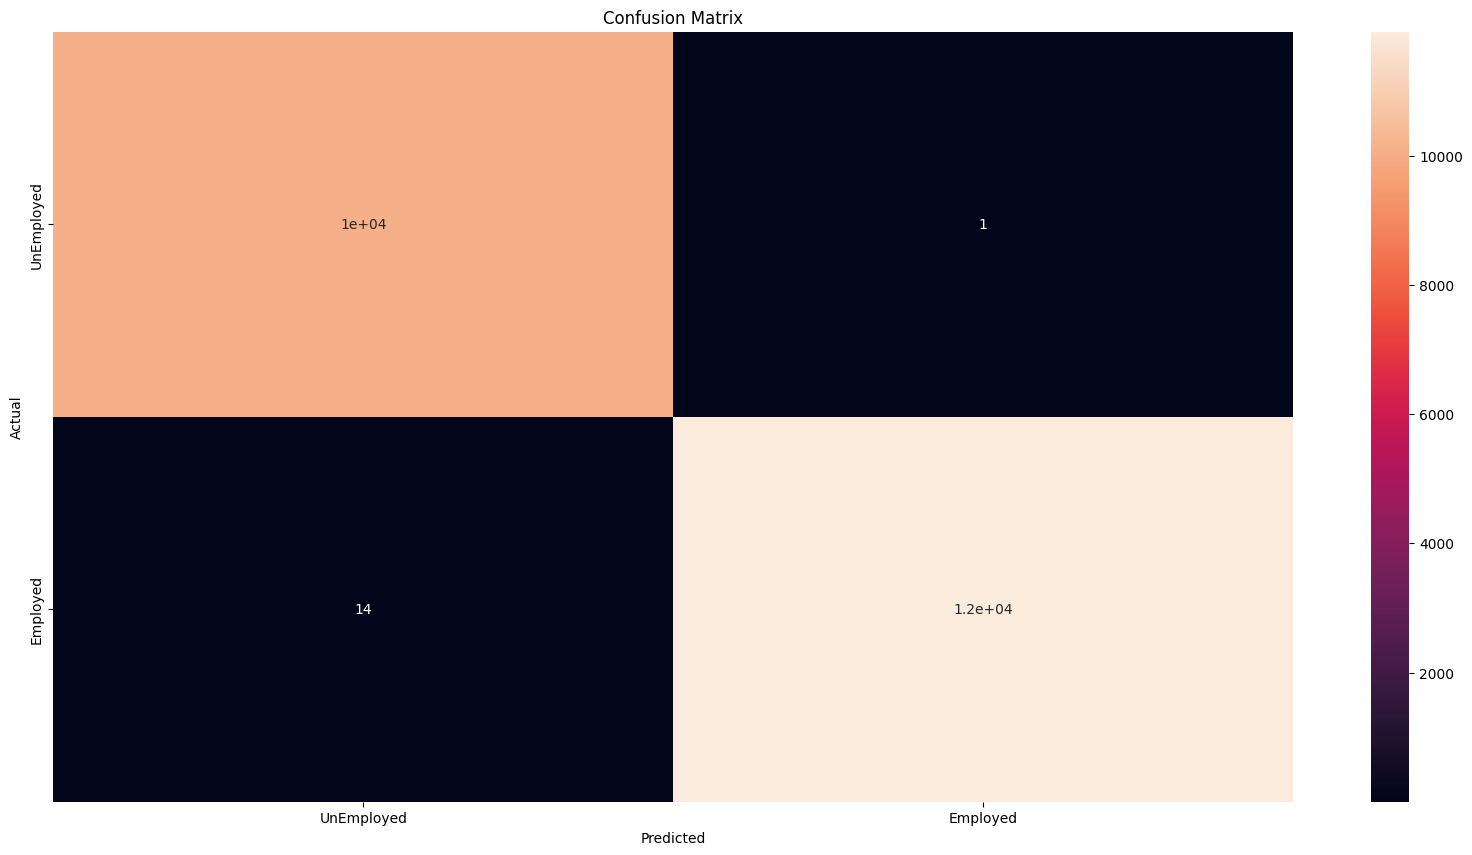

In [37]:
confusionMatrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(20,10))
sns.heatmap(confusionMatrix, annot=True, xticklabels=["UnEmployed", "Employed"], yticklabels=["UnEmployed", "Employed"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## 10 Fold Cross Validation Score

In [38]:
cross_val_score(randomForest, scaler.transform(x), y, cv=10)

array([0.99986376, 1.        , 0.99891008, 0.99972752, 0.99945504,
       0.99918256, 0.99850136, 0.99918256, 0.9993188 , 0.99850116])

# **Post-modeling Insights**

## **Feature Importance**

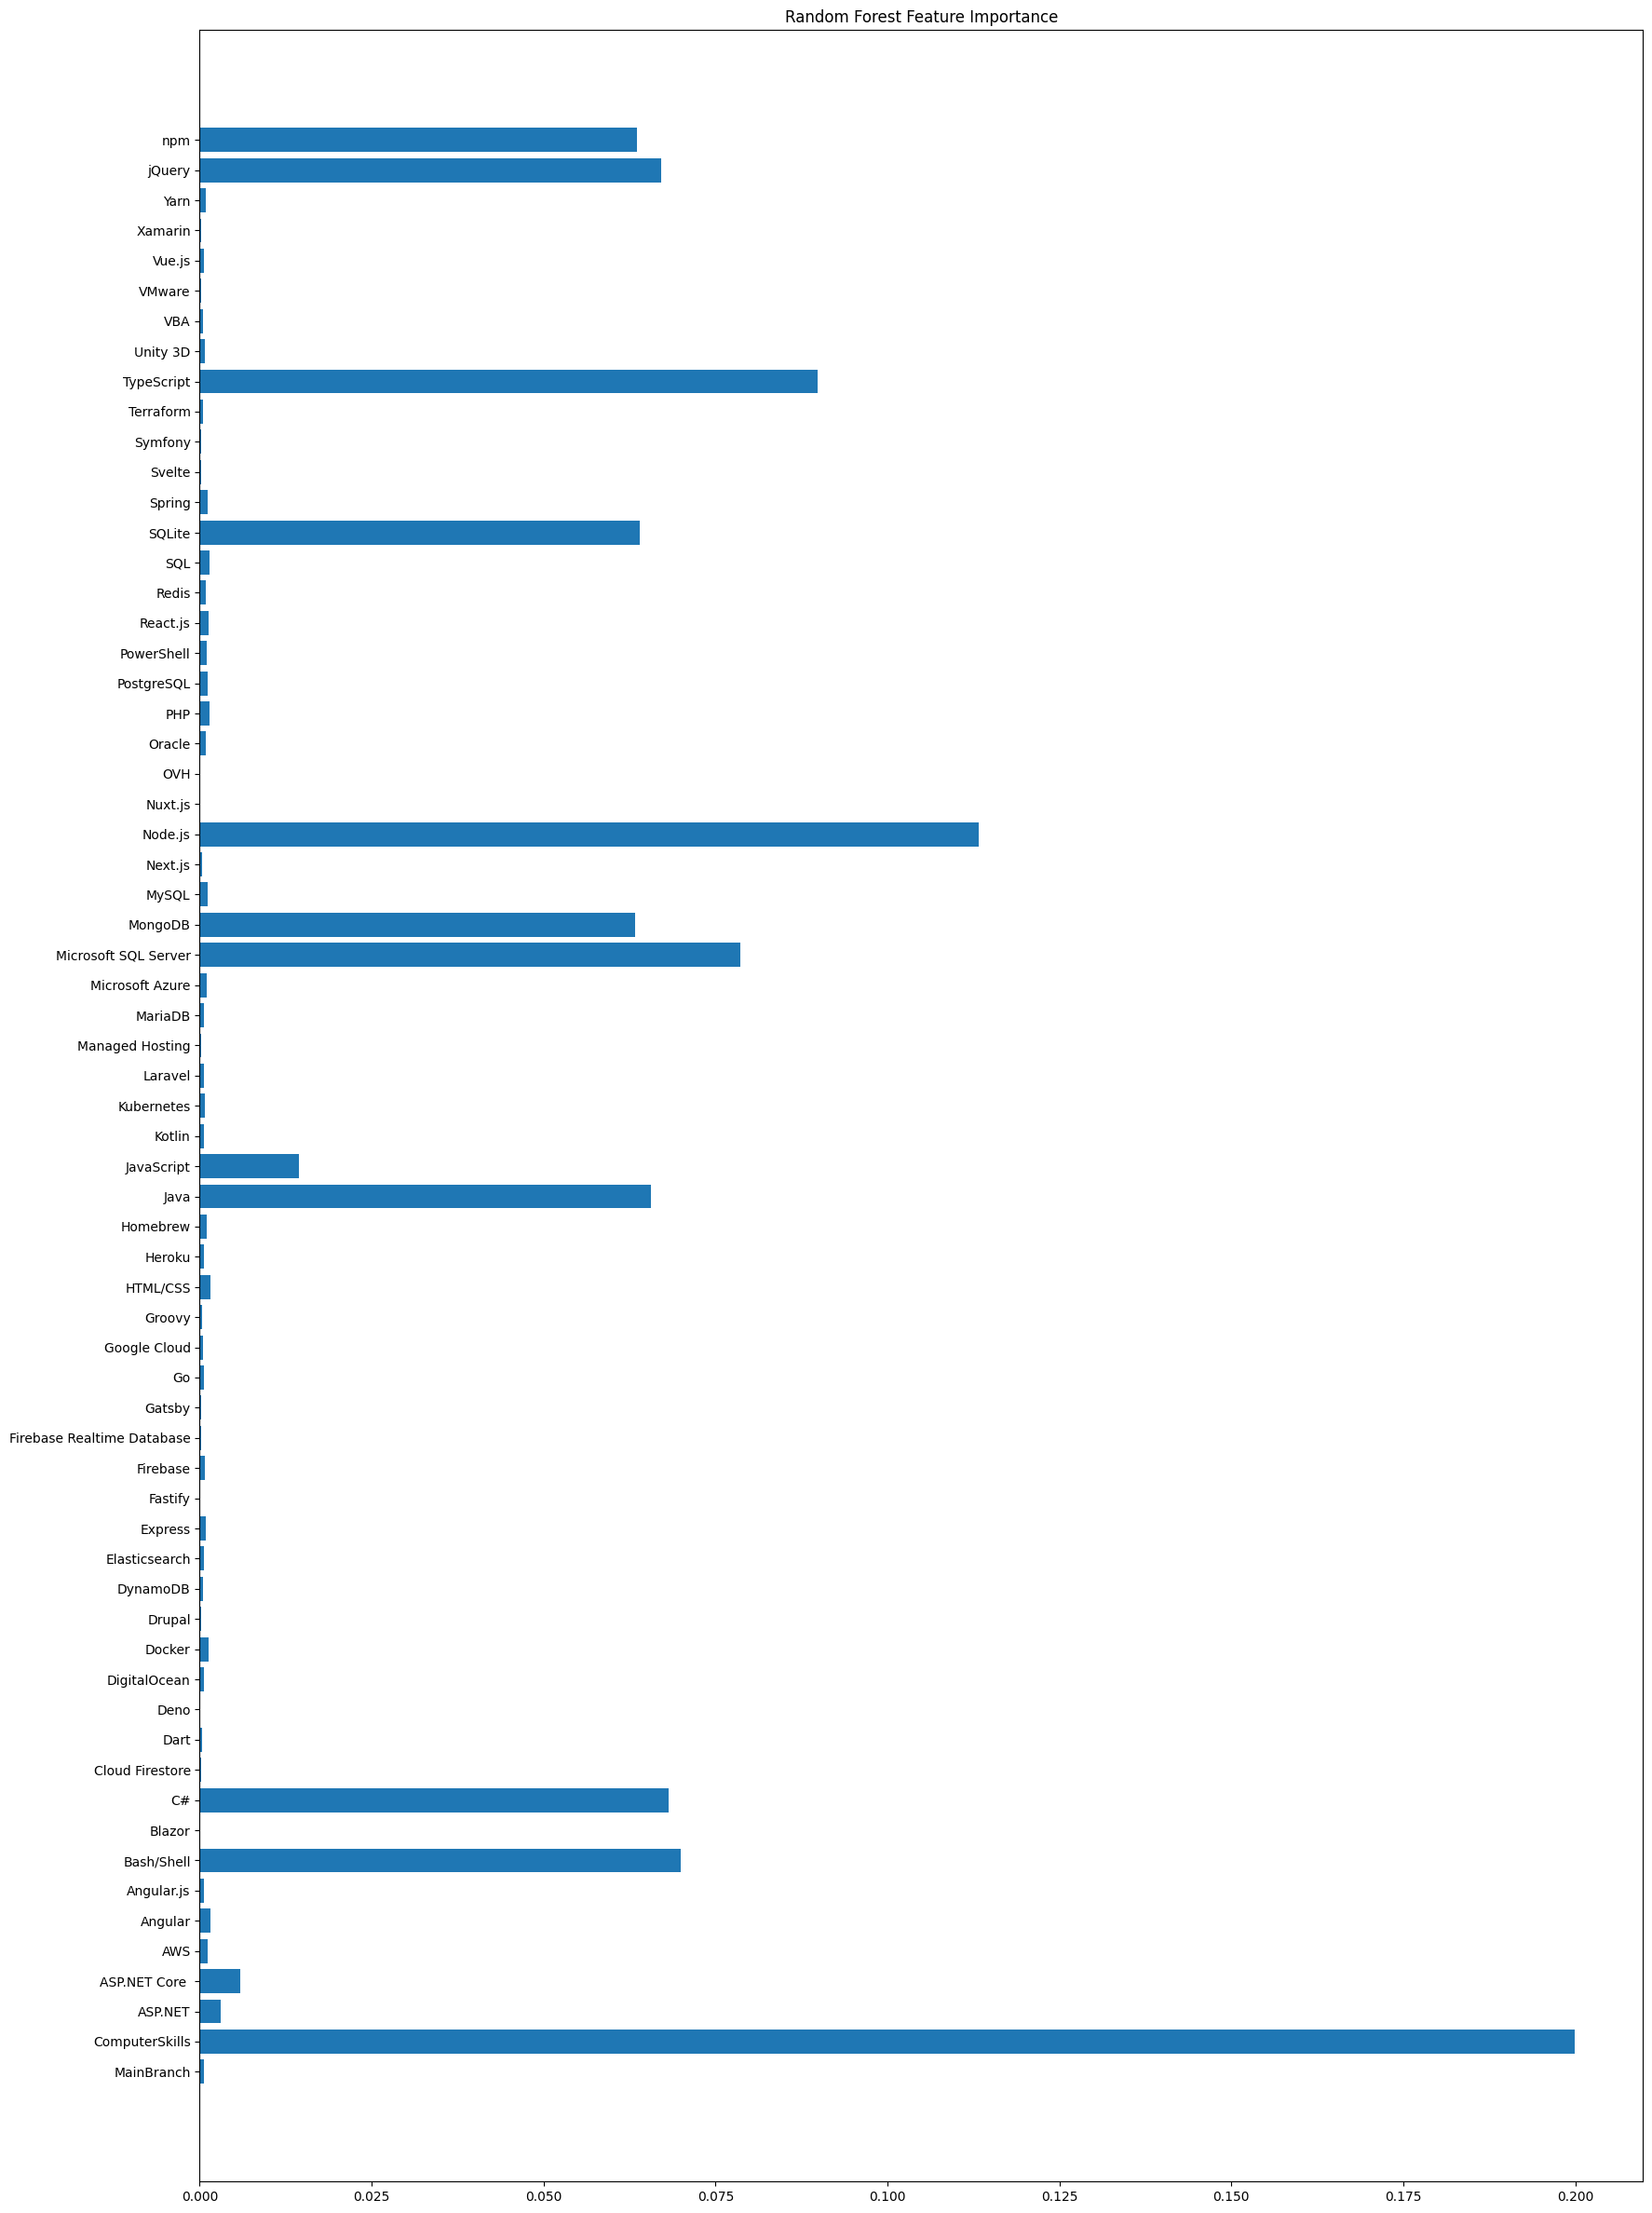

In [39]:
plt.figure(figsize=(20,30))
plt.barh(x.columns, randomForest.feature_importances_)
plt.title("Random Forest Feature Importance")
plt.show()

## **SHAP Visualize**

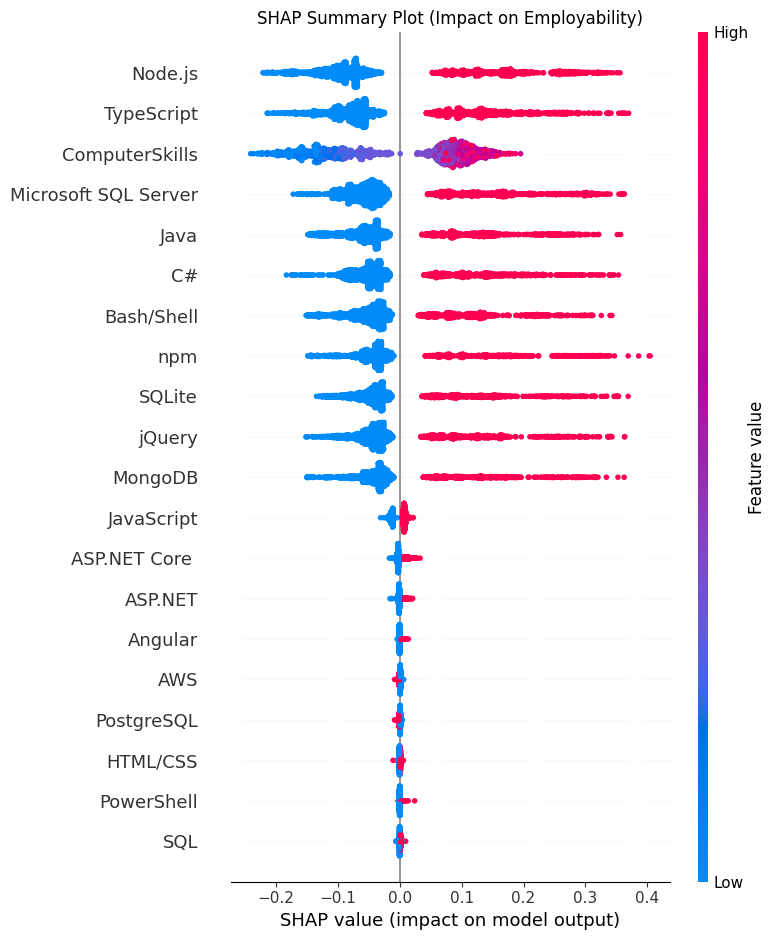

In [40]:
explainer = shap.TreeExplainer(randomForest)

sampled_x_test = x_test[np.random.choice(x_test.shape[0], 2000, replace=False)]
shap_values = explainer.shap_values(sampled_x_test)

plt.title("SHAP Summary Plot (Impact on Employability)")
shap.summary_plot(shap_values[:, :, 1], sampled_x_test, plot_type="dot", feature_names=x.columns)

***จากการวิเคราะห์ด้วย SHAP Value พบว่า***
- ComputerSkills มีผลกระทบสูงสุดต่อการถูกรับเข้าทำงาน รองลงมาคือ Node.js, TypeScript, Microsoft SQL Server, C#, Java
แปลว่า ทักษะคอมพิวเตอร์โดยรวม และทักษะสาย Dev/Backend มีน้ำหนักต่อโอกาสได้งานมาก

- ค่า Feature สูง ดันโอกาสได้งานเพิ่ม หมายถึงผู้ที่มีทักษะนั้นๆ จะเพิ่มความน่าจะเป็นในการได้งาน เช่น Node.js, TypeScript, SQL, MongoDB, npm เป็นต้น

- ขาดทักษะการทำงานในหัวข้อนั้นๆ จะลดโอกาสได้งาน ตัวอย่างเช่น Java, C#, Bash/Shell

- ทักษะที่เกี่ยวข้องกับ Web และ Development stack รวมถึง ทักษะสำหรับ Database เช่น: JavaScript, jQuery, npm, Node.js, Microsoft SQL Server, SQLite, MongoDB
มีแนวโน้มที่จะถูกรับเข้าทำงาน แสดงว่าบริษัทนี้ให้คุณค่ากับสาย Web/Software Developer สูง

---

***สรุป Insight***

- ผู้สมัครที่มีทักษะ Programming (Full Stack Developer) + Database จะเพิ่มโอกาสได้งานมากที่สุด

- ผู้สมัครที่มีหลายทักษะทางเทคนิคพร้อมกัน จะถูกประเมินสูงกว่า

- การพัฒนาทักษะ ComputerSkills โดยรวม (ไม่ใช่แค่ภาษาเดียว) ให้ผลกระทบเชิงบวกสูงสุด